In [ ]:
# load dependencies
%matplotlib inline
import matplotlib.pyplot as plt
import numpy
import numpy as np
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

SystemError: <class '_frozen_importlib._ModuleLockManager'> returned a result with an error set

ImportError: numpy.core._multiarray_umath failed to import

ImportError: numpy.core.umath failed to import

In [4]:
tx_energy = pd.read_csv("texas_energy_production.csv")  #usecols=[1],engine='python'
# texas_energy.set_index('Years', inplace=True)
tx_energy.head()

,Unnamed: 0,Years,Coal_prod,Gas_prod,Oil_prod,Renewable_en_prod,Total_en_prod,Total_en_consumption
0,0,1960,26409.0,6602696.0,5379378.0,50155.0,12058639.0,4416216.0
1,1,1961,26535.0,6682140.0,5447308.0,52023.0,12208006.0,4447880.0
2,2,1962,25855.0,6812787.0,5471272.0,47721.0,12357635.0,4640675.0
3,3,1963,27441.0,6952455.0,5671135.0,42718.0,12693749.0,4894089.0
4,4,1964,28839.0,7311876.0,5739216.0,43884.0,13123816.0,5012683.0


# Texas Coal forcast model 

In [5]:
tx_coal = tx_energy[["Coal_prod"]]
tx_coal.head()
# tx_coal.shape

,Coal_prod
0,26409.0
1,26535.0
2,25855.0
3,27441.0
4,28839.0


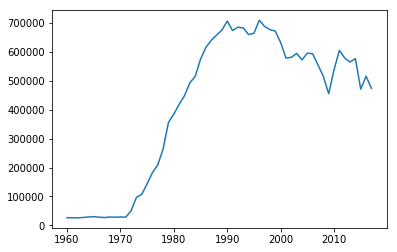

In [6]:
plt.plot(tx_energy.Years,tx_coal.Coal_prod)

In [7]:
tx_coal = tx_coal.values
tx_coal = tx_coal.astype('float32')

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
tx_coal = scaler.fit_transform(tx_coal)

In [9]:
# split into train and test sets
train_size = int(len(tx_coal) * 0.67)
test_size = len(tx_coal) - train_size
train, test = tx_coal[0:train_size,:], tx_coal[train_size:len(tx_coal),:]

In [10]:
# convert an array of values into a dataset matrix
def create_dataset(state_data, look_back=1):
	dataX, dataY = [], []
	for i in range(len(state_data)-look_back-1):
		a = state_data[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(state_data[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [11]:
# reshape into X=t and Y=t+1
look_back= 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [12]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [13]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
 - 2s - loss: 0.3606
Epoch 2/100
 - 0s - loss: 0.3063
Epoch 3/100
 - 0s - loss: 0.2621
Epoch 4/100
 - 0s - loss: 0.2262
Epoch 5/100
 - 0s - loss: 0.1937
Epoch 6/100
 - 0s - loss: 0.1691
Epoch 7/100
 - 0s - loss: 0.1492
Epoch 8/100
 - 0s - loss: 0.1324
Epoch 9/100
 - 0s - loss: 0.1186
Epoch 10/100
 - 0s - loss: 0.1078
Epoch 11/100
 - 0s - loss: 0.0991
Epoch 12/100
 - 0s - loss: 0.0905
Epoch 13/100
 - 0s - loss: 0.0839
Epoch 14/100
 - 0s - loss: 0.0772
Epoch 15/100
 - 0s - loss: 0.0713
Epoch 16/100
 - 0s - loss: 0.0660
Epoch 17/100
 - 0s - loss: 0.0610
Epoch 18/100
 - 0s - loss: 0.0559
Epoch 19/100
 - 0s - loss: 0.0511
Epoch 20/100
 - 0s - loss: 0.0466
Epoch 21/100
 - 0s - loss: 0.0425
Epoch 22/100
 - 0s - loss: 0.0384
Epoch 23/100
 - 0s - loss: 0.0343
Epoch 24/100
 - 0s - loss: 0.0309
Epoch 25/100
 - 0s - loss: 0.0276
Epoch 26/100
 - 0s - loss: 0.0240
Epoch

In [14]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [15]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 19382.84 RMSE
Test Score: 58111.17 RMSE


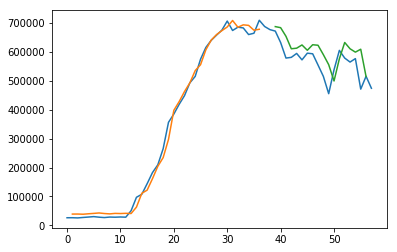

In [16]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(tx_coal)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(tx_coal)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(tx_coal)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(tx_coal))
plt.plot(trainPredictPlot)

plt.plot(testPredictPlot)
plt.show()

In [17]:
# re-train the LSTM on all data
look_back = 30 # look back further
trainX, trainY = create_dataset(tx_coal, look_back)
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))

# re-create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 2s - loss: 0.2887
Epoch 2/100
 - 0s - loss: 0.1328
Epoch 3/100
 - 0s - loss: 0.0722
Epoch 4/100
 - 0s - loss: 0.0503
Epoch 5/100
 - 0s - loss: 0.0392
Epoch 6/100
 - 0s - loss: 0.0328
Epoch 7/100
 - 0s - loss: 0.0268
Epoch 8/100
 - 0s - loss: 0.0233
Epoch 9/100
 - 0s - loss: 0.0192
Epoch 10/100
 - 0s - loss: 0.0165
Epoch 11/100
 - 0s - loss: 0.0147
Epoch 12/100
 - 0s - loss: 0.0130
Epoch 13/100
 - 0s - loss: 0.0113
Epoch 14/100
 - 0s - loss: 0.0102
Epoch 15/100
 - 0s - loss: 0.0093
Epoch 16/100
 - 0s - loss: 0.0087
Epoch 17/100
 - 0s - loss: 0.0080
Epoch 18/100
 - 0s - loss: 0.0077
Epoch 19/100
 - 0s - loss: 0.0073
Epoch 20/100
 - 0s - loss: 0.0068
Epoch 21/100
 - 0s - loss: 0.0066
Epoch 22/100
 - 0s - loss: 0.0062
Epoch 23/100
 - 0s - loss: 0.0060
Epoch 24/100
 - 0s - loss: 0.0060
Epoch 25/100
 - 0s - loss: 0.0057
Epoch 26/100
 - 0s - loss: 0.0054
Epoch 27/100
 - 0s - loss: 0.0053
Epoch 28/100
 - 0s - loss: 0.0051
Epoch 29/100
 - 0s - loss: 0.0050
Epoch 30/100
 - 0s - lo

58


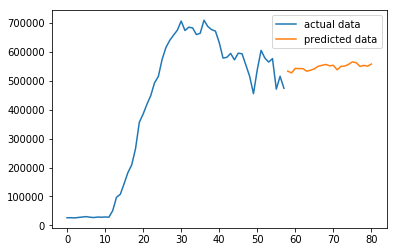

In [18]:
# making future prediction
flatten_state_data = tx_coal.reshape(-1)
val = flatten_state_data[-look_back:] # last batch in the training data
pred_list = []
for i in range(23): # predict the next 23 points
    pred = model.predict(val.reshape(1,1,look_back))
    pred_list = np.append(pred_list,pred)
    val = np.append(np.delete(val, 0), pred) # update the data batch to be fed in the next iteration
pred_list = pred_list.reshape(pred_list.shape[0],1)

# invert prediction
pred_list = scaler.inverse_transform(pred_list)

# plot
data_len = len(tx_coal)
print(data_len)
plt.plot(list(range(data_len)),scaler.inverse_transform(tx_coal),label="actual data")
plt.plot(list(range(data_len,data_len+len(pred_list))),pred_list,label="predicted data")
plt.legend()
plt.show()

Texas Coal production 1960-2040 dataframe

In [19]:
L = pred_list
L

array([[533583.92859234],
       [527386.4611917 ],
       [542925.7888943 ],
       [542160.64581767],
       [542276.29134419],
       [533225.54155719],
       [536636.51410422],
       [541519.54255172],
       [550200.49559695],
       [553610.44942017],
       [556583.8597178 ],
       [552069.81303303],
       [553560.73569841],
       [538106.08431861],
       [550026.57906869],
       [550980.02305372],
       [556940.77979067],
       [565479.19300087],
       [562600.5647662 ],
       [549933.71220648],
       [553230.0579508 ],
       [550669.8420291 ],
       [557943.40776108]])

In [20]:
tx_coal_pre = pd.DataFrame(L, columns=["Coal_prod"])
tx_coal_pre.head()

,Coal_prod
0,533583.928592
1,527386.461192
2,542925.788894
3,542160.645818
4,542276.291344


In [21]:
pre_yrs = numpy.arange(2018, 2041, 1).tolist()
pre_yrs = pd.DataFrame({"Years":pre_yrs})
pre_yrs.head()

,Years
0,2018
1,2019
2,2020
3,2021
4,2022


In [22]:

coal_pred = pd.concat([pre_yrs, tx_coal_pre], axis=1, sort=False)
coal_pred.head()

,Years,Coal_prod
0,2018,533583.928592
1,2019,527386.461192
2,2020,542925.788894
3,2021,542160.645818
4,2022,542276.291344


In [23]:
tx_coal = tx_energy[["Years", "Coal_prod"]]
tx_coal.head()

,Years,Coal_prod
0,1960,26409.0
1,1961,26535.0
2,1962,25855.0
3,1963,27441.0
4,1964,28839.0


In [24]:
TexasCoal_prod_pre = pd.concat([tx_coal, coal_pred])
TexasCoal_prod_pre

,Years,Coal_prod
0,1960,26409.000000
1,1961,26535.000000
2,1962,25855.000000
3,1963,27441.000000
4,1964,28839.000000
5,1965,30349.000000
6,1966,28360.000000
7,1967,27102.000000
8,1968,28839.000000
9,1969,28310.000000


# Texas Gas Forcasting model

In [25]:
tx_gas = tx_energy[["Gas_prod"]]
tx_gas.head()

,Gas_prod
0,6602696.0
1,6682140.0
2,6812787.0
3,6952455.0
4,7311876.0


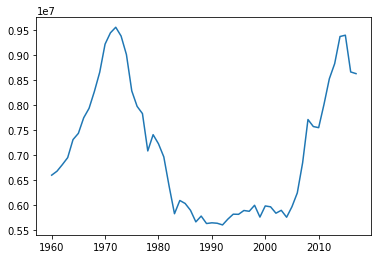

In [26]:
plt.plot(tx_energy.Years,tx_gas.Gas_prod)

In [27]:

scaler_tx_gas  = MinMaxScaler(feature_range=(0, 1))
tx_gas = scaler_tx_gas.fit_transform(tx_gas)

In [28]:
# split into train and test sets
train_size_tx_gas  = int(len(tx_gas ) * 0.67)
test_size_tx_gas  = len(tx_gas) - train_size_tx_gas 
train_tx_gas , test_tx_gas  = tx_gas [0:train_size_tx_gas,:], tx_gas [train_size_tx_gas :len(tx_gas),:]

In [29]:
# convert an array of values into a dataset matrix
def create_tx_gas(tx_gas, look_back=1):
	dataX_tx_gas, dataY_tx_gas = [], []
	for i_tx_gas in range(len(tx_gas)-look_back-1):
		a_tx_gas = tx_gas[i_tx_gas:(i_tx_gas+look_back), 0]
		dataX_tx_gas.append(a_tx_gas)
		dataY_tx_gas.append(tx_gas[i_tx_gas + look_back, 0])
	return numpy.array(dataX_tx_gas), numpy.array(dataY_tx_gas)

In [30]:
# reshape into X=t and Y=t+1
look_back = 1
trainX_tx_gas, trainY_tx_gas = create_tx_gas(train_tx_gas, look_back)
testX_tx_gas, testY_tx_gas = create_tx_gas(test_tx_gas, look_back)

In [31]:
# reshape input to be [samples, time steps, features]
trainX_tx_gas = numpy.reshape(trainX_tx_gas, (trainX_tx_gas.shape[0], 1, trainX_tx_gas.shape[1]))
testX_tx_gas = numpy.reshape(testX_tx_gas, (testX_tx_gas.shape[0], 1, testX_tx_gas.shape[1]))

In [32]:
# create and fit the LSTM network
model_tx_gas = Sequential()
model_tx_gas.add(LSTM(4, input_shape=(1, look_back)))
model_tx_gas.add(Dense(1))
model_tx_gas.compile(loss='mean_squared_error', optimizer='adam')
model_tx_gas.fit(trainX_tx_gas, trainY_tx_gas, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 2s - loss: 0.2572
Epoch 2/100
 - 0s - loss: 0.2248
Epoch 3/100
 - 0s - loss: 0.1979
Epoch 4/100
 - 0s - loss: 0.1730
Epoch 5/100
 - 0s - loss: 0.1529
Epoch 6/100
 - 0s - loss: 0.1357
Epoch 7/100
 - 0s - loss: 0.1214
Epoch 8/100
 - 0s - loss: 0.1090
Epoch 9/100
 - 0s - loss: 0.0995
Epoch 10/100
 - 0s - loss: 0.0917
Epoch 11/100
 - 0s - loss: 0.0853
Epoch 12/100
 - 0s - loss: 0.0805
Epoch 13/100
 - 0s - loss: 0.0758
Epoch 14/100
 - 0s - loss: 0.0723
Epoch 15/100
 - 0s - loss: 0.0690
Epoch 16/100
 - 0s - loss: 0.0659
Epoch 17/100
 - 0s - loss: 0.0632
Epoch 18/100
 - 0s - loss: 0.0605
Epoch 19/100
 - 0s - loss: 0.0575
Epoch 20/100
 - 0s - loss: 0.0547
Epoch 21/100
 - 0s - loss: 0.0519
Epoch 22/100
 - 0s - loss: 0.0491
Epoch 23/100
 - 0s - loss: 0.0462
Epoch 24/100
 - 0s - loss: 0.0440
Epoch 25/100
 - 0s - loss: 0.0408
Epoch 26/100
 - 0s - loss: 0.0376
Epoch 27/100
 - 0s - loss: 0.0348
Epoch 28/100
 - 0s - loss: 0.0317
Epoch 29/100
 - 0s - loss: 0.0293
Epoch 30/100
 - 0s - lo

In [33]:
# make predictions
trainPredict_tx_gas = model_tx_gas.predict(trainX_tx_gas)
testPredict_tx_gas = model_tx_gas.predict(testX_tx_gas)

In [34]:
# invert predictions
trainPredict_tx_gas = scaler_tx_gas.inverse_transform(trainPredict_tx_gas)
trainY_tx_gas = scaler_tx_gas.inverse_transform([trainY_tx_gas])
testPredict_tx_gas = scaler_tx_gas.inverse_transform(testPredict_tx_gas)
testY_tx_gas = scaler_tx_gas.inverse_transform([testY_tx_gas])
# calculate root mean squared error
trainScore_tx_gas = math.sqrt(mean_squared_error(trainY_tx_gas[0], trainPredict_tx_gas[:,0]))
print('Train Score: %.2f RMSE' % (trainScore_tx_gas))
testScore_tx_gas = math.sqrt(mean_squared_error(testY_tx_gas[0], testPredict_tx_gas[:,0]))
print('Test Score: %.2f RMSE' % (testScore_tx_gas))

Train Score: 303669.54 RMSE
Test Score: 405549.39 RMSE


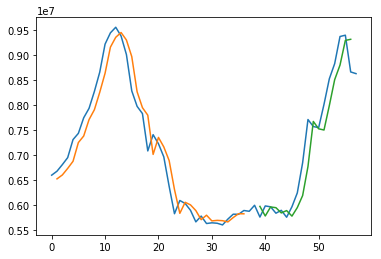

In [35]:
# shift train predictions for plotting
trainPredictPlot_tx_gas = numpy.empty_like(tx_gas)
trainPredictPlot_tx_gas[:, :] = numpy.nan
trainPredictPlot_tx_gas[look_back:len(trainPredict_tx_gas)+look_back, :] = trainPredict_tx_gas
# shift test predictions for plotting
testPredictPlot_tx_gas = numpy.empty_like(tx_gas)
testPredictPlot_tx_gas[:, :] = numpy.nan
testPredictPlot_tx_gas[len(trainPredict_tx_gas)+(look_back*2)+1:len(tx_gas)-1, :] = testPredict_tx_gas
# plot baseline and predictions
plt.plot(scaler_tx_gas.inverse_transform(tx_gas))
plt.plot(trainPredictPlot_tx_gas)
plt.plot(testPredictPlot_tx_gas)
plt.show()

In [36]:
# re-train the LSTM on all data
look_back = 30 # look back further
trainX_tx_gas, trainY_tx_gas = create_tx_gas(tx_gas, look_back)
trainX_tx_gas = numpy.reshape(trainX_tx_gas, (trainX_tx_gas.shape[0], 1, trainX_tx_gas.shape[1]))

# re-create and fit the LSTM network
model_tx_gas = Sequential()
model_tx_gas.add(LSTM(4, input_shape=(1, look_back)))
model_tx_gas.add(Dense(1))
model_tx_gas.compile(loss='mean_squared_error', optimizer='adam')
model_tx_gas.fit(trainX_tx_gas, trainY_tx_gas, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 2s - loss: 0.2493
Epoch 2/100
 - 0s - loss: 0.2051
Epoch 3/100
 - 0s - loss: 0.1748
Epoch 4/100
 - 0s - loss: 0.1501
Epoch 5/100
 - 0s - loss: 0.1312
Epoch 6/100
 - 0s - loss: 0.1123
Epoch 7/100
 - 0s - loss: 0.0953
Epoch 8/100
 - 0s - loss: 0.0803
Epoch 9/100
 - 0s - loss: 0.0678
Epoch 10/100
 - 0s - loss: 0.0557
Epoch 11/100
 - 0s - loss: 0.0463
Epoch 12/100
 - 0s - loss: 0.0387
Epoch 13/100
 - 0s - loss: 0.0321
Epoch 14/100
 - 0s - loss: 0.0271
Epoch 15/100
 - 0s - loss: 0.0228
Epoch 16/100
 - 0s - loss: 0.0193
Epoch 17/100
 - 0s - loss: 0.0161
Epoch 18/100
 - 0s - loss: 0.0141
Epoch 19/100
 - 0s - loss: 0.0123
Epoch 20/100
 - 0s - loss: 0.0107
Epoch 21/100
 - 0s - loss: 0.0095
Epoch 22/100
 - 0s - loss: 0.0087
Epoch 23/100
 - 0s - loss: 0.0078
Epoch 24/100
 - 0s - loss: 0.0072
Epoch 25/100
 - 0s - loss: 0.0066
Epoch 26/100
 - 0s - loss: 0.0062
Epoch 27/100
 - 0s - loss: 0.0059
Epoch 28/100
 - 0s - loss: 0.0057
Epoch 29/100
 - 0s - loss: 0.0054
Epoch 30/100
 - 0s - lo

58


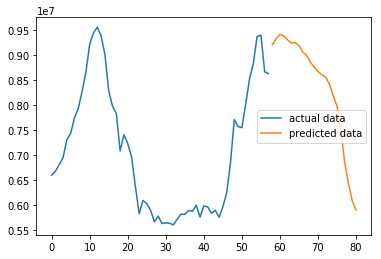

In [37]:
# making future prediction
flatten_tx_gas = tx_gas.reshape(-1)
val_tx_gas = flatten_tx_gas[-look_back:] # last batch in the training data
pred_list_tx_gas = []
for i_tx_gas in range(23): # predict the next 23 points
    pred_tx_gas = model_tx_gas.predict(val_tx_gas.reshape(1,1,look_back))
    pred_list_tx_gas = np.append(pred_list_tx_gas,pred_tx_gas)
    val_tx_gas = np.append(np.delete(val_tx_gas, 0),pred_tx_gas) # update the data batch to be fed in the next iteration
pred_list_tx_gas = pred_list_tx_gas.reshape(pred_list_tx_gas.shape[0],1)

# invert prediction
pred_list_tx_gas = scaler_tx_gas.inverse_transform(pred_list_tx_gas)

# plot
tx_gas_len = len(tx_gas)
print(tx_gas_len)
plt.plot(list(range(tx_gas_len)),scaler_tx_gas.inverse_transform(tx_gas),label="actual data")
plt.plot(list(range(tx_gas_len,tx_gas_len+len(pred_list_tx_gas))),pred_list_tx_gas,label="predicted data")
plt.legend()
plt.show()

texas gas production 1960-2040

In [38]:
L_gas = pred_list_tx_gas
tx_gas_pre = pd.DataFrame(L_gas, columns=["Gas_prod"])
tx_gas_pre.head()
# pre_yrs = numpy.arange(2018, 2041, 1).tolist()
# pre_yrs = pd.DataFrame({"Years":pre_yrs})
# pre_yrs.head()
gas_pred = pd.concat([pre_yrs, tx_gas_pre], axis=1, sort=False)
gas_pred.head()
tx_gas = tx_energy[["Years", "Gas_prod"]]
tx_gas.head()
Texasgas_prod_pre = pd.concat([tx_gas, gas_pred])
Texasgas_prod_pre.head()

,Years,Gas_prod
0,1960,6602696.0
1,1961,6682140.0
2,1962,6812787.0
3,1963,6952455.0
4,1964,7311876.0


# Texas Oil Forcasting  model 

In [69]:
tx_oil = tx_energy[["Oil_prod"]]
tx_oil.head()

,Oil_prod
0,5379378.0
1,5447308.0
2,5471272.0
3,5671135.0
4,5739216.0


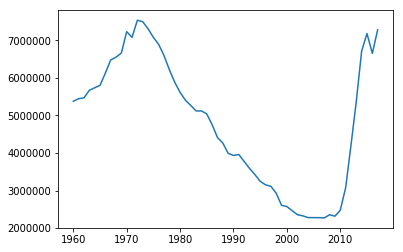

In [70]:
tx_oil = tx_energy[["Oil_prod"]]
tx_oil.head()
plt.plot(tx_energy.Years,tx_oil.Oil_prod)


In [71]:
scaler_tx_oil  = MinMaxScaler(feature_range=(0, 1))
tx_oil = scaler_tx_oil.fit_transform(tx_oil)

# split into train and test sets
train_size_tx_oil  = int(len(tx_oil) * 0.67)
test_size_tx_oil  = len(tx_oil) - train_size_tx_oil 
train_tx_oil , test_tx_oil  = tx_oil [0:train_size_tx_oil,:], tx_oil [train_size_tx_oil :len(tx_oil),:]

# convert an array of values into a dataset matrix
def create_tx_oil(tx_oil, look_back=1):
	dataX_tx_oil, dataY_tx_oil = [], []
	for i_tx_oil in range(len(tx_oil)-look_back-1):
		a_tx_oil = tx_oil[i_tx_oil:(i_tx_oil+look_back), 0]
		dataX_tx_oil.append(a_tx_oil)
		dataY_tx_oil.append(tx_oil[i_tx_oil + look_back, 0])
	return numpy.array(dataX_tx_oil), numpy.array(dataY_tx_oil)

# reshape into X=t and Y=t+1
look_back = 1
trainX_tx_oil, trainY_tx_oil = create_tx_oil(train_tx_oil, look_back)
testX_tx_oil, testY_tx_oil = create_tx_oil(test_tx_oil, look_back)


# reshape input to be [samples, time steps, features]
trainX_tx_oil = numpy.reshape(trainX_tx_oil, (trainX_tx_oil.shape[0], 1, trainX_tx_oil.shape[1]))
testX_tx_oil = numpy.reshape(testX_tx_oil, (testX_tx_oil.shape[0], 1, testX_tx_oil.shape[1]))

# create and fit the LSTM network
model_tx_oil = Sequential()
model_tx_oil.add(LSTM(4, input_shape=(1, look_back)))
model_tx_oil.add(Dense(1))
model_tx_oil.compile(loss='mean_squared_error', optimizer='adam')
model_tx_oil.fit(trainX_tx_oil, trainY_tx_oil, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 4s - loss: 0.4051
Epoch 2/100
 - 0s - loss: 0.3119
Epoch 3/100
 - 0s - loss: 0.2378
Epoch 4/100
 - 0s - loss: 0.1789
Epoch 5/100
 - 0s - loss: 0.1354
Epoch 6/100
 - 0s - loss: 0.1022
Epoch 7/100
 - 0s - loss: 0.0784
Epoch 8/100
 - 0s - loss: 0.0623
Epoch 9/100
 - 0s - loss: 0.0516
Epoch 10/100
 - 0s - loss: 0.0443
Epoch 11/100
 - 0s - loss: 0.0397
Epoch 12/100
 - 0s - loss: 0.0369
Epoch 13/100
 - 0s - loss: 0.0352
Epoch 14/100
 - 0s - loss: 0.0335
Epoch 15/100
 - 0s - loss: 0.0323
Epoch 16/100
 - 0s - loss: 0.0316
Epoch 17/100
 - 0s - loss: 0.0303
Epoch 18/100
 - 0s - loss: 0.0295
Epoch 19/100
 - 0s - loss: 0.0287
Epoch 20/100
 - 0s - loss: 0.0278
Epoch 21/100
 - 0s - loss: 0.0267
Epoch 22/100
 - 0s - loss: 0.0258
Epoch 23/100
 - 0s - loss: 0.0250
Epoch 24/100
 - 0s - loss: 0.0239
Epoch 25/100
 - 0s - loss: 0.0231
Epoch 26/100
 - 0s - loss: 0.0222
Epoch 27/100
 - 0s - loss: 0.0215
Epoch 28/100
 - 0s - loss: 0.0208
Epoch 29/100
 - 0s - loss: 0.0197
Epoch 30/100
 - 0s - lo

In [72]:
# make predictions
trainPredict_tx_oil = model_tx_oil.predict(trainX_tx_oil)
testPredict_tx_oil = model_tx_oil.predict(testX_tx_oil)
# invert predictions
trainPredict_tx_oil = scaler_tx_oil.inverse_transform(trainPredict_tx_oil)
trainY_tx_oil = scaler_tx_oil.inverse_transform([trainY_tx_oil])
testPredict_tx_oil = scaler_tx_oil.inverse_transform(testPredict_tx_oil)
testY_tx_oil = scaler_tx_oil.inverse_transform([testY_tx_oil])
# calculate root mean squared error
trainScore_tx_oil = math.sqrt(mean_squared_error(trainY_tx_oil[0], trainPredict_tx_oil[:,0]))
print('Train Score: %.2f RMSE' % (trainScore_tx_oil))
testScore_tx_oil = math.sqrt(mean_squared_error(testY_tx_oil[0], testPredict_tx_oil[:,0]))
print('Test Score: %.2f RMSE' % (testScore_tx_oil))

Train Score: 214200.42 RMSE
Test Score: 579157.38 RMSE


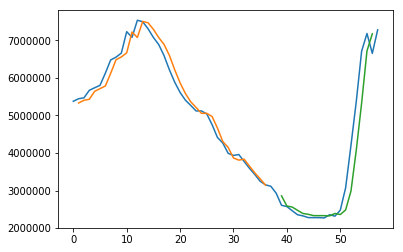

In [73]:
# shift train predictions for plotting
trainPredictPlot_tx_oil = numpy.empty_like(tx_oil)
trainPredictPlot_tx_oil[:, :] = numpy.nan
trainPredictPlot_tx_oil[look_back:len(trainPredict_tx_oil)+look_back, :] = trainPredict_tx_oil
# shift test predictions for plotting
testPredictPlot_tx_oil = numpy.empty_like(tx_oil)
testPredictPlot_tx_oil[:, :] = numpy.nan
testPredictPlot_tx_oil[len(trainPredict_tx_oil)+(look_back*2)+1:len(tx_oil)-1, :] = testPredict_tx_oil
# plot baseline and predictions
plt.plot(scaler_tx_oil.inverse_transform(tx_oil))
plt.plot(trainPredictPlot_tx_oil)
plt.plot(testPredictPlot_tx_oil)
plt.show()

In [74]:
# re-train the LSTM on all data
look_back = 30 # look back further
trainX_tx_oil, trainY_tx_oil = create_tx_oil(tx_oil, look_back)
trainX_tx_oil = numpy.reshape(trainX_tx_oil, (trainX_tx_oil.shape[0], 1, trainX_tx_oil.shape[1]))

# re-create and fit the LSTM network
model_tx_oil = Sequential()
model_tx_oil.add(LSTM(4, input_shape=(1, look_back)))
model_tx_oil.add(Dense(1))
model_tx_oil.compile(loss='mean_squared_error', optimizer='adam')
model_tx_oil.fit(trainX_tx_oil, trainY_tx_oil, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 4s - loss: 0.1055
Epoch 2/100
 - 0s - loss: 0.0731
Epoch 3/100
 - 0s - loss: 0.0697
Epoch 4/100
 - 0s - loss: 0.0650
Epoch 5/100
 - 0s - loss: 0.0610
Epoch 6/100
 - 0s - loss: 0.0571
Epoch 7/100
 - 0s - loss: 0.0532
Epoch 8/100
 - 0s - loss: 0.0511
Epoch 9/100
 - 0s - loss: 0.0455
Epoch 10/100
 - 0s - loss: 0.0420
Epoch 11/100
 - 0s - loss: 0.0387
Epoch 12/100
 - 0s - loss: 0.0351
Epoch 13/100
 - 0s - loss: 0.0319
Epoch 14/100
 - 0s - loss: 0.0291
Epoch 15/100
 - 0s - loss: 0.0265
Epoch 16/100
 - 0s - loss: 0.0250
Epoch 17/100
 - 0s - loss: 0.0225
Epoch 18/100
 - 0s - loss: 0.0203
Epoch 19/100
 - 0s - loss: 0.0180
Epoch 20/100
 - 0s - loss: 0.0165
Epoch 21/100
 - 0s - loss: 0.0162
Epoch 22/100
 - 0s - loss: 0.0141
Epoch 23/100
 - 0s - loss: 0.0149
Epoch 24/100
 - 0s - loss: 0.0136
Epoch 25/100
 - 0s - loss: 0.0126
Epoch 26/100
 - 0s - loss: 0.0125
Epoch 27/100
 - 0s - loss: 0.0118
Epoch 28/100
 - 0s - loss: 0.0113
Epoch 29/100
 - 0s - loss: 0.0112
Epoch 30/100
 - 0s - lo

58


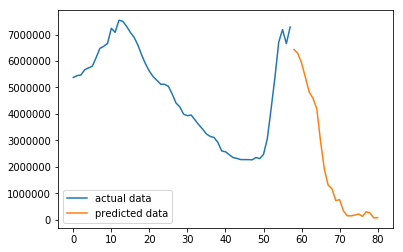

In [68]:
# making future prediction
flatten_tx_oil = tx_oil.reshape(-1)
val_tx_oil = flatten_tx_oil[-look_back:] # last batch in the training data
pred_list_tx_oil = []
for i_tx_oil in range(23): # predict the next 23 points
    pred_tx_oil = model_tx_oil.predict(val_tx_oil.reshape(1,1,look_back))
    pred_list_tx_oil = np.append(pred_list_tx_oil,pred_tx_oil)
    val_tx_oil = np.append(np.delete(val_tx_oil, 0),pred_tx_oil) # update the data batch to be fed in the next iteration
pred_list_tx_oil = pred_list_tx_oil.reshape(pred_list_tx_oil.shape[0],1)

# invert prediction
pred_list_tx_oil = scaler_tx_oil.inverse_transform(pred_list_tx_oil)

# plot
tx_oil_len = len(tx_oil)
print(tx_oil_len)
plt.plot(list(range(tx_oil_len)),scaler_tx_oil.inverse_transform(tx_oil),label="actual data")
plt.plot(list(range(tx_oil_len,tx_oil_len+len(pred_list_tx_oil))),pred_list_tx_oil,label="predicted data")
plt.legend()
plt.show()

texas crude oil production 1965-2040

In [46]:
L_oil = pred_list_tx_oil
tx_oil_pre = pd.DataFrame(L_oil, columns=["Oil_prod"])
# tx_oil_pre.head()
# pre_yrs = numpy.arange(2018, 2041, 1).tolist()
# pre_yrs = pd.DataFrame({"Years":pre_yrs})
# pre_yrs.head()
oil_pred = pd.concat([pre_yrs, tx_oil_pre], axis=1, sort=False)
gas_pred.head()
tx_oil = tx_energy[["Years", "Oil_prod"]]
tx_oil.head()
TexasOil_prod_pre = pd.concat([tx_oil, oil_pred])
TexasOil_prod_pre.head()

,Years,Oil_prod
0,1960,5379378.0
1,1961,5447308.0
2,1962,5471272.0
3,1963,5671135.0
4,1964,5739216.0


# Texas Renewable_en_prod  Forcasting model 

In [47]:
tx_Renewable = tx_energy[["Renewable_en_prod"]]
tx_Renewable.head()


,Renewable_en_prod
0,50155.0
1,52023.0
2,47721.0
3,42718.0
4,43884.0


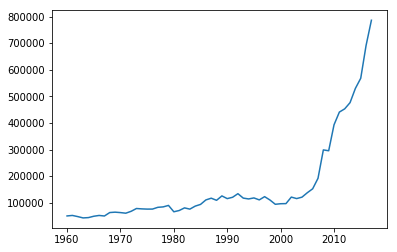

In [48]:
plt.plot(tx_energy.Years,tx_Renewable.Renewable_en_prod)

In [49]:
scaler_tx_Renewable  = MinMaxScaler(feature_range=(0, 1))
tx_Renewable = scaler_tx_Renewable.fit_transform(tx_Renewable)

# split into train and test sets
train_size_tx_Renewable  = int(len(tx_Renewable) * 0.67)
test_size_tx_Renewable  = len(tx_Renewable) - train_size_tx_Renewable 
train_tx_Renewable , test_tx_Renewable  = tx_Renewable [0:train_size_tx_Renewable,:], tx_Renewable [train_size_tx_Renewable :len(tx_Renewable),:]

# convert an array of values into a dataset matrix
def create_tx_Renewable(tx_Renewable, look_back=1):
	dataX_tx_Renewable, dataY_tx_Renewable = [], []
	for i_tx_Renewable in range(len(tx_Renewable)-look_back-1):
		a_tx_Renewable = tx_Renewable[i_tx_Renewable:(i_tx_Renewable+look_back), 0]
		dataX_tx_Renewable.append(a_tx_Renewable)
		dataY_tx_Renewable.append(tx_Renewable[i_tx_Renewable + look_back, 0])
	return numpy.array(dataX_tx_Renewable), numpy.array(dataY_tx_Renewable)

# reshape into X=t and Y=t+1
look_back = 1
trainX_tx_Renewable, trainY_tx_Renewable = create_tx_Renewable(train_tx_Renewable, look_back)
testX_tx_Renewable, testY_tx_Renewable = create_tx_Renewable(test_tx_Renewable, look_back)


# reshape input to be [samples, time steps, features]
trainX_tx_Renewable = numpy.reshape(trainX_tx_Renewable, (trainX_tx_Renewable.shape[0], 1, trainX_tx_Renewable.shape[1]))
testX_tx_Renewable = numpy.reshape(testX_tx_Renewable, (testX_tx_Renewable.shape[0], 1, testX_tx_Renewable.shape[1]))

# create and fit the LSTM network
model_tx_Renewable = Sequential()
model_tx_Renewable.add(LSTM(4, input_shape=(1, look_back)))
model_tx_Renewable.add(Dense(1))
model_tx_Renewable.compile(loss='mean_squared_error', optimizer='adam')
model_tx_Renewable.fit(trainX_tx_Renewable, trainY_tx_Renewable, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 3s - loss: 0.0017
Epoch 2/100
 - 0s - loss: 9.5419e-04
Epoch 3/100
 - 0s - loss: 9.2861e-04
Epoch 4/100
 - 0s - loss: 8.8941e-04
Epoch 5/100
 - 0s - loss: 8.6474e-04
Epoch 6/100
 - 0s - loss: 8.4565e-04
Epoch 7/100
 - 0s - loss: 8.0056e-04
Epoch 8/100
 - 0s - loss: 7.8328e-04
Epoch 9/100
 - 0s - loss: 7.7442e-04
Epoch 10/100
 - 0s - loss: 7.1291e-04
Epoch 11/100
 - 0s - loss: 6.7144e-04
Epoch 12/100
 - 0s - loss: 6.4495e-04
Epoch 13/100
 - 0s - loss: 6.0422e-04
Epoch 14/100
 - 0s - loss: 5.6901e-04
Epoch 15/100
 - 0s - loss: 5.4810e-04
Epoch 16/100
 - 0s - loss: 4.7347e-04
Epoch 17/100
 - 0s - loss: 4.6199e-04
Epoch 18/100
 - 0s - loss: 4.2850e-04
Epoch 19/100
 - 0s - loss: 3.7659e-04
Epoch 20/100
 - 0s - loss: 3.8056e-04
Epoch 21/100
 - 0s - loss: 3.2495e-04
Epoch 22/100
 - 0s - loss: 2.9342e-04
Epoch 23/100
 - 0s - loss: 2.6848e-04
Epoch 24/100
 - 0s - loss: 2.5259e-04
Epoch 25/100
 - 0s - loss: 2.4221e-04
Epoch 26/100
 - 0s - loss: 2.1808e-04
Epoch 27/100
 - 0s - loss

In [50]:
# make predictions
trainPredict_tx_Renewable = model_tx_Renewable.predict(trainX_tx_Renewable)
testPredict_tx_Renewable = model_tx_Renewable.predict(testX_tx_Renewable)
# invert predictions
trainPredict_tx_Renewable = scaler_tx_Renewable.inverse_transform(trainPredict_tx_Renewable)
trainY_tx_Renewable = scaler_tx_Renewable.inverse_transform([trainY_tx_Renewable])
testPredict_tx_Renewable = scaler_tx_Renewable.inverse_transform(testPredict_tx_Renewable)
testY_tx_Renewable = scaler_tx_Renewable.inverse_transform([testY_tx_Renewable])
# calculate root mean squared error
trainScore_tx_Renewable = math.sqrt(mean_squared_error(trainY_tx_Renewable[0], trainPredict_tx_Renewable[:,0]))
print('Train Score: %.2f RMSE' % (trainScore_tx_Renewable))
testScore_tx_Renewable = math.sqrt(mean_squared_error(testY_tx_Renewable[0], testPredict_tx_Renewable[:,0]))
print('Test Score: %.2f RMSE' % (testScore_tx_Renewable))

Train Score: 8647.26 RMSE
Test Score: 70111.52 RMSE


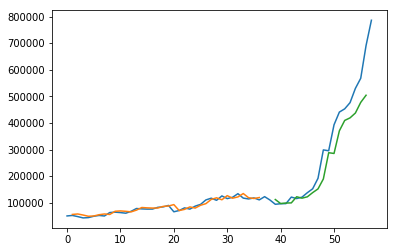

In [51]:
# shift train predictions for plotting
trainPredictPlot_tx_Renewable = numpy.empty_like(tx_Renewable)
trainPredictPlot_tx_Renewable[:, :] = numpy.nan
trainPredictPlot_tx_Renewable[look_back:len(trainPredict_tx_Renewable)+look_back, :] = trainPredict_tx_Renewable
# shift test predictions for plotting
testPredictPlot_tx_Renewable = numpy.empty_like(tx_Renewable)
testPredictPlot_tx_Renewable[:, :] = numpy.nan
testPredictPlot_tx_Renewable[len(trainPredict_tx_Renewable)+(look_back*2)+1:len(tx_Renewable)-1, :] = testPredict_tx_Renewable
# plot baseline and predictions
plt.plot(scaler_tx_Renewable.inverse_transform(tx_Renewable))
plt.plot(trainPredictPlot_tx_Renewable)
plt.plot(testPredictPlot_tx_Renewable)
plt.show()

In [52]:
# re-train the LSTM on all data
look_back = 30 # look back further
trainX_tx_Renewable, trainY_tx_Renewable = create_tx_Renewable(tx_Renewable, look_back)
trainX_tx_Renewable = numpy.reshape(trainX_tx_Renewable, (trainX_tx_Renewable.shape[0], 1, trainX_tx_Renewable.shape[1]))

# re-create and fit the LSTM network
model_tx_Renewable = Sequential()
model_tx_Renewable.add(LSTM(4, input_shape=(1, look_back)))
model_tx_Renewable.add(Dense(1))
model_tx_Renewable.compile(loss='mean_squared_error', optimizer='adam')
model_tx_Renewable.fit(trainX_tx_Renewable, trainY_tx_Renewable, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 3s - loss: 0.1094
Epoch 2/100
 - 0s - loss: 0.0911
Epoch 3/100
 - 0s - loss: 0.0766
Epoch 4/100
 - 0s - loss: 0.0625
Epoch 5/100
 - 0s - loss: 0.0528
Epoch 6/100
 - 0s - loss: 0.0446
Epoch 7/100
 - 0s - loss: 0.0377
Epoch 8/100
 - 0s - loss: 0.0334
Epoch 9/100
 - 0s - loss: 0.0305
Epoch 10/100
 - 0s - loss: 0.0278
Epoch 11/100
 - 0s - loss: 0.0254
Epoch 12/100
 - 0s - loss: 0.0238
Epoch 13/100
 - 0s - loss: 0.0220
Epoch 14/100
 - 0s - loss: 0.0197
Epoch 15/100
 - 0s - loss: 0.0182
Epoch 16/100
 - 0s - loss: 0.0165
Epoch 17/100
 - 0s - loss: 0.0148
Epoch 18/100
 - 0s - loss: 0.0133
Epoch 19/100
 - 0s - loss: 0.0123
Epoch 20/100
 - 0s - loss: 0.0107
Epoch 21/100
 - 0s - loss: 0.0095
Epoch 22/100
 - 0s - loss: 0.0088
Epoch 23/100
 - 0s - loss: 0.0074
Epoch 24/100
 - 0s - loss: 0.0067
Epoch 25/100
 - 0s - loss: 0.0060
Epoch 26/100
 - 0s - loss: 0.0054
Epoch 27/100
 - 0s - loss: 0.0049
Epoch 28/100
 - 0s - loss: 0.0045
Epoch 29/100
 - 0s - loss: 0.0043
Epoch 30/100
 - 0s - lo

Epoch 1/100
 - 3s - loss: 0.0449
Epoch 2/100
 - 0s - loss: 0.0278
Epoch 3/100
 - 0s - loss: 0.0201
Epoch 4/100
 - 0s - loss: 0.0162
Epoch 5/100
 - 0s - loss: 0.0140
Epoch 6/100
 - 0s - loss: 0.0124
Epoch 7/100
 - 0s - loss: 0.0110
Epoch 8/100
 - 0s - loss: 0.0095
Epoch 9/100
 - 0s - loss: 0.0085
Epoch 10/100
 - 0s - loss: 0.0073
Epoch 11/100
 - 0s - loss: 0.0064
Epoch 12/100
 - 0s - loss: 0.0056
Epoch 13/100
 - 0s - loss: 0.0049
Epoch 14/100
 - 0s - loss: 0.0046
Epoch 15/100
 - 0s - loss: 0.0041
Epoch 16/100
 - 0s - loss: 0.0038
Epoch 17/100
 - 0s - loss: 0.0036
Epoch 18/100
 - 0s - loss: 0.0034
Epoch 19/100
 - 0s - loss: 0.0032
Epoch 20/100
 - 0s - loss: 0.0032
Epoch 21/100
 - 0s - loss: 0.0030
Epoch 22/100
 - 0s - loss: 0.0029
Epoch 23/100
 - 0s - loss: 0.0030
Epoch 24/100
 - 0s - loss: 0.0027
Epoch 25/100
 - 0s - loss: 0.0027
Epoch 26/100
 - 0s - loss: 0.0026
Epoch 27/100
 - 0s - loss: 0.0025
Epoch 28/100
 - 0s - loss: 0.0025
Epoch 29/100
 - 0s - loss: 0.0024
Epoch 30/100
 - 0s - lo

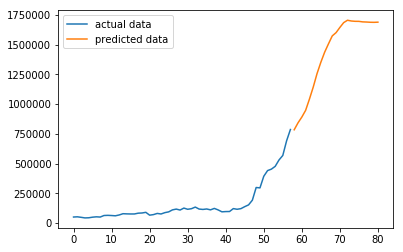

In [53]:
# re-train the LSTM on all data
look_back = 30 # look back further
trainX_tx_Renewable, trainY_tx_Renewable = create_tx_Renewable(tx_Renewable, look_back)
trainX_tx_Renewable = numpy.reshape(trainX_tx_Renewable, (trainX_tx_Renewable.shape[0], 1, trainX_tx_Renewable.shape[1]))

# re-create and fit the LSTM network
model_tx_Renewable = Sequential()
model_tx_Renewable.add(LSTM(4, input_shape=(1, look_back)))
model_tx_Renewable.add(Dense(1))
model_tx_Renewable.compile(loss='mean_squared_error', optimizer='adam')
model_tx_Renewable.fit(trainX_tx_Renewable, trainY_tx_Renewable, epochs=100, batch_size=1, verbose=2)


# making future prediction
flatten_tx_Renewable = tx_Renewable.reshape(-1)
val_tx_Renewable = flatten_tx_Renewable[-look_back:] # last batch in the training data
pred_list_tx_Renewable = []
for i_tx_Renewable in range(23): # predict the next 23 points
    pred_tx_Renewable = model_tx_Renewable.predict(val_tx_Renewable.reshape(1,1,look_back))
    pred_list_tx_Renewable = np.append(pred_list_tx_Renewable,pred_tx_Renewable)
    val_tx_Renewable = np.append(np.delete(val_tx_Renewable, 0),pred_tx_Renewable) # update the data batch to be fed in the next iteration
pred_list_tx_Renewable = pred_list_tx_Renewable.reshape(pred_list_tx_Renewable.shape[0],1)

# invert prediction
pred_list_tx_Renewable = scaler_tx_Renewable.inverse_transform(pred_list_tx_Renewable)

# plot
tx_Renewable_len = len(tx_Renewable)
print(tx_oil_len)
plt.plot(list(range(tx_Renewable_len)),scaler_tx_Renewable.inverse_transform(tx_Renewable),label="actual data")
plt.plot(list(range(tx_Renewable_len,tx_Renewable_len+len(pred_list_tx_Renewable))),pred_list_tx_Renewable,label="predicted data")
plt.legend()
plt.show()

texas renewable energy production 1965-2040

In [54]:
L_Renewable = pred_list_tx_Renewable
tx_Renewable_pre = pd.DataFrame(L_Renewable, columns=["Renewable_en_prod"])
# tx_Renewable_pre.head()
# pre_yrs = numpy.arange(2018, 2041, 1).tolist()
# pre_yrs = pd.DataFrame({"Years":pre_yrs})
# pre_yrs.head()
Renewable_pred = pd.concat([pre_yrs, tx_Renewable_pre], axis=1, sort=False)
Renewable_pred.head()
tx_Renewable = tx_energy[["Years", "Renewable_en_prod"]]
tx_Renewable.head()
TexasRenewable_prod_pre = pd.concat([tx_Renewable, Renewable_pred])
TexasRenewable_prod_pre.head()

,Years,Renewable_en_prod
0,1960,50155.0
1,1961,52023.0
2,1962,47721.0
3,1963,42718.0
4,1964,43884.0


# Texas Total Energy production Forcasting model 

In [57]:
tx_TotalEnergy= tx_energy[["Total_en_prod"]]
tx_TotalEnergy.head()

,Total_en_prod
0,12058639.0
1,12208006.0
2,12357635.0
3,12693749.0
4,13123816.0


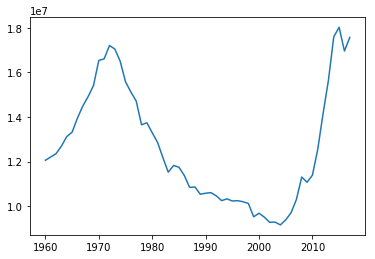

In [58]:
tx_TotalEnergy= tx_energy[["Total_en_prod"]]
tx_TotalEnergy.head()
plt.plot(tx_energy.Years,tx_TotalEnergy.Total_en_prod)

In [59]:
scaler_tx_TotalEnergy  = MinMaxScaler(feature_range=(0, 1))
tx_TotalEnergy = scaler_tx_TotalEnergy.fit_transform(tx_TotalEnergy)

# split into train and test sets
train_size_tx_TotalEnergy  = int(len(tx_TotalEnergy) * 0.67)
test_size_tx_TotalEnergy  = len(tx_TotalEnergy) - train_size_tx_TotalEnergy 
train_tx_TotalEnergy , test_tx_TotalEnergy  = tx_TotalEnergy [0:train_size_tx_TotalEnergy,:], tx_TotalEnergy [train_size_tx_TotalEnergy :len(tx_TotalEnergy),:]

# convert an array of values into a dataset matrix
def create_tx_TotalEnergy(tx_TotalEnergy, look_back=1):
	dataX_tx_TotalEnergy, dataY_tx_TotalEnergy = [], []
	for i_tx_TotalEnergy in range(len(tx_TotalEnergy)-look_back-1):
		a_tx_TotalEnergy = tx_TotalEnergy[i_tx_TotalEnergy:(i_tx_TotalEnergy+look_back), 0]
		dataX_tx_TotalEnergy.append(a_tx_TotalEnergy)
		dataY_tx_TotalEnergy.append(tx_TotalEnergy[i_tx_TotalEnergy + look_back, 0])
	return numpy.array(dataX_tx_TotalEnergy), numpy.array(dataY_tx_TotalEnergy)

# reshape into X=t and Y=t+1
look_back = 1
trainX_tx_TotalEnergy, trainY_tx_TotalEnergy = create_tx_TotalEnergy(train_tx_TotalEnergy, look_back)
testX_tx_TotalEnergy, testY_tx_TotalEnergy = create_tx_TotalEnergy(test_tx_TotalEnergy, look_back)


# reshape input to be [samples, time steps, features]
trainX_tx_TotalEnergy = numpy.reshape(trainX_tx_TotalEnergy, (trainX_tx_TotalEnergy.shape[0], 1, trainX_tx_TotalEnergy.shape[1]))
testX_tx_TotalEnergy = numpy.reshape(testX_tx_TotalEnergy, (testX_tx_TotalEnergy.shape[0], 1, testX_tx_TotalEnergy.shape[1]))

# create and fit the LSTM network
model_tx_TotalEnergy = Sequential()
model_tx_TotalEnergy.add(LSTM(4, input_shape=(1, look_back)))
model_tx_TotalEnergy.add(Dense(1))
model_tx_TotalEnergy.compile(loss='mean_squared_error', optimizer='adam')
model_tx_TotalEnergy.fit(trainX_tx_TotalEnergy, trainY_tx_TotalEnergy, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 4s - loss: 0.2192
Epoch 2/100
 - 0s - loss: 0.1722
Epoch 3/100
 - 0s - loss: 0.1343
Epoch 4/100
 - 0s - loss: 0.1035
Epoch 5/100
 - 0s - loss: 0.0822
Epoch 6/100
 - 0s - loss: 0.0654
Epoch 7/100
 - 0s - loss: 0.0536
Epoch 8/100
 - 0s - loss: 0.0464
Epoch 9/100
 - 0s - loss: 0.0414
Epoch 10/100
 - 0s - loss: 0.0382
Epoch 11/100
 - 0s - loss: 0.0361
Epoch 12/100
 - 0s - loss: 0.0346
Epoch 13/100
 - 0s - loss: 0.0334
Epoch 14/100
 - 0s - loss: 0.0322
Epoch 15/100
 - 0s - loss: 0.0309
Epoch 16/100
 - 0s - loss: 0.0297
Epoch 17/100
 - 0s - loss: 0.0286
Epoch 18/100
 - 0s - loss: 0.0276
Epoch 19/100
 - 0s - loss: 0.0265
Epoch 20/100
 - 0s - loss: 0.0255
Epoch 21/100
 - 0s - loss: 0.0240
Epoch 22/100
 - 0s - loss: 0.0232
Epoch 23/100
 - 0s - loss: 0.0219
Epoch 24/100
 - 0s - loss: 0.0208
Epoch 25/100
 - 0s - loss: 0.0200
Epoch 26/100
 - 0s - loss: 0.0188
Epoch 27/100
 - 0s - loss: 0.0177
Epoch 28/100
 - 0s - loss: 0.0167
Epoch 29/100
 - 0s - loss: 0.0160
Epoch 30/100
 - 0s - lo

Train Score: 461454.69 RMSE
Test Score: 880388.19 RMSE


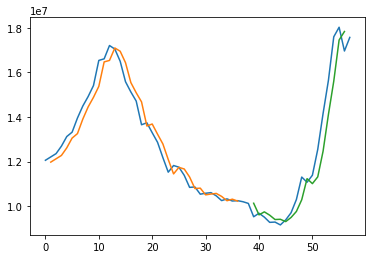

In [60]:
# make predictions
trainPredict_tx_TotalEnergy = model_tx_TotalEnergy.predict(trainX_tx_TotalEnergy)
testPredict_tx_TotalEnergy = model_tx_TotalEnergy.predict(testX_tx_TotalEnergy)
# invert predictions
trainPredict_tx_TotalEnergy = scaler_tx_TotalEnergy.inverse_transform(trainPredict_tx_TotalEnergy)
trainY_tx_TotalEnergy = scaler_tx_TotalEnergy.inverse_transform([trainY_tx_TotalEnergy])
testPredict_tx_TotalEnergy = scaler_tx_TotalEnergy.inverse_transform(testPredict_tx_TotalEnergy)
testY_tx_TotalEnergy = scaler_tx_TotalEnergy.inverse_transform([testY_tx_TotalEnergy])
# calculate root mean squared error
trainScore_tx_TotalEnergy = math.sqrt(mean_squared_error(trainY_tx_TotalEnergy[0], trainPredict_tx_TotalEnergy[:,0]))
print('Train Score: %.2f RMSE' % (trainScore_tx_TotalEnergy))
testScore_tx_TotalEnergy = math.sqrt(mean_squared_error(testY_tx_TotalEnergy[0], testPredict_tx_TotalEnergy[:,0]))
print('Test Score: %.2f RMSE' % (testScore_tx_TotalEnergy))

# shift train predictions for plotting
trainPredictPlot_tx_TotalEnergy = numpy.empty_like(tx_TotalEnergy)
trainPredictPlot_tx_TotalEnergy[:, :] = numpy.nan
trainPredictPlot_tx_TotalEnergy[look_back:len(trainPredict_tx_TotalEnergy)+look_back, :] = trainPredict_tx_TotalEnergy
# shift test predictions for plotting
testPredictPlot_tx_TotalEnergy = numpy.empty_like(tx_TotalEnergy)
testPredictPlot_tx_TotalEnergy[:, :] = numpy.nan
testPredictPlot_tx_TotalEnergy[len(trainPredict_tx_TotalEnergy)+(look_back*2)+1:len(tx_TotalEnergy)-1, :] = testPredict_tx_TotalEnergy
# plot baseline and predictions
plt.plot(scaler_tx_TotalEnergy.inverse_transform(tx_TotalEnergy))
plt.plot(trainPredictPlot_tx_TotalEnergy)
plt.plot(testPredictPlot_tx_TotalEnergy)
plt.show()

Epoch 1/100
 - 4s - loss: 0.1619
Epoch 2/100
 - 0s - loss: 0.1427
Epoch 3/100
 - 0s - loss: 0.1318
Epoch 4/100
 - 0s - loss: 0.1205
Epoch 5/100
 - 0s - loss: 0.1104
Epoch 6/100
 - 0s - loss: 0.1023
Epoch 7/100
 - 0s - loss: 0.0943
Epoch 8/100
 - 0s - loss: 0.0867
Epoch 9/100
 - 0s - loss: 0.0794
Epoch 10/100
 - 0s - loss: 0.0736
Epoch 11/100
 - 0s - loss: 0.0658
Epoch 12/100
 - 0s - loss: 0.0597
Epoch 13/100
 - 0s - loss: 0.0547
Epoch 14/100
 - 0s - loss: 0.0471
Epoch 15/100
 - 0s - loss: 0.0425
Epoch 16/100
 - 0s - loss: 0.0365
Epoch 17/100
 - 0s - loss: 0.0325
Epoch 18/100
 - 0s - loss: 0.0274
Epoch 19/100
 - 0s - loss: 0.0240
Epoch 20/100
 - 0s - loss: 0.0207
Epoch 21/100
 - 0s - loss: 0.0176
Epoch 22/100
 - 0s - loss: 0.0152
Epoch 23/100
 - 0s - loss: 0.0134
Epoch 24/100
 - 0s - loss: 0.0119
Epoch 25/100
 - 0s - loss: 0.0110
Epoch 26/100
 - 0s - loss: 0.0095
Epoch 27/100
 - 0s - loss: 0.0087
Epoch 28/100
 - 0s - loss: 0.0082
Epoch 29/100
 - 0s - loss: 0.0078
Epoch 30/100
 - 0s - lo

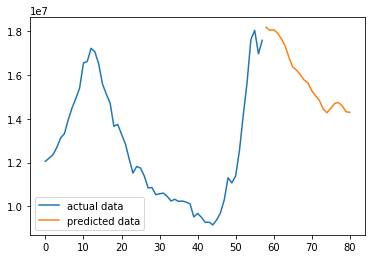

In [61]:
# re-train the LSTM on all data
look_back = 30 # look back further
trainX_tx_TotalEnergy, trainY_tx_TotalEnergy = create_tx_TotalEnergy(tx_TotalEnergy, look_back)
trainX_tx_TotalEnergy = numpy.reshape(trainX_tx_TotalEnergy, (trainX_tx_TotalEnergy.shape[0], 1, trainX_tx_TotalEnergy.shape[1]))

# re-create and fit the LSTM network
model_tx_TotalEnergy = Sequential()
model_tx_TotalEnergy.add(LSTM(4, input_shape=(1, look_back)))
model_tx_TotalEnergy.add(Dense(1))
model_tx_TotalEnergy.compile(loss='mean_squared_error', optimizer='adam')
model_tx_TotalEnergy.fit(trainX_tx_TotalEnergy, trainY_tx_TotalEnergy, epochs=100, batch_size=1, verbose=2)


# making future prediction
flatten_tx_TotalEnergy = tx_TotalEnergy.reshape(-1)
val_tx_TotalEnergy = flatten_tx_TotalEnergy[-look_back:] # last batch in the training data
pred_list_tx_TotalEnergy = []
for i_tx_TotalEnergy in range(23): # predict the next 23 points
    pred_tx_TotalEnergy = model_tx_TotalEnergy.predict(val_tx_TotalEnergy.reshape(1,1,look_back))
    pred_list_tx_TotalEnergy = np.append(pred_list_tx_TotalEnergy,pred_tx_TotalEnergy)
    val_tx_TotalEnergy = np.append(np.delete(val_tx_TotalEnergy, 0),pred_tx_TotalEnergy) # update the data batch to be fed in the next iteration
pred_list_tx_TotalEnergy = pred_list_tx_TotalEnergy.reshape(pred_list_tx_TotalEnergy.shape[0],1)

# invert prediction
pred_list_tx_TotalEnergy = scaler_tx_TotalEnergy.inverse_transform(pred_list_tx_TotalEnergy)

# plot
tx_TotalEnergy_len = len(tx_TotalEnergy)
print(tx_oil_len)
plt.plot(list(range(tx_TotalEnergy_len)),scaler_tx_TotalEnergy.inverse_transform(tx_TotalEnergy),label="actual data")
plt.plot(list(range(tx_TotalEnergy_len,tx_TotalEnergy_len+len(pred_list_tx_TotalEnergy))),pred_list_tx_TotalEnergy,label="predicted data")
plt.legend()
plt.show()

texas renewable energy production 1965-2040

In [62]:
L_TotalEnergy = pred_list_tx_TotalEnergy
tx_TotalEnergy_pre = pd.DataFrame(L_TotalEnergy, columns=["Total_en_prod"])
# tx_TotalEnergy_pre.head()
# pre_yrs = numpy.arange(2018, 2041, 1).tolist()
# pre_yrs = pd.DataFrame({"Years":pre_yrs})
# pre_yrs.head()
TotalEnergy_pred = pd.concat([pre_yrs, tx_TotalEnergy_pre], axis=1, sort=False)
TotalEnergy_pred.head()
tx_TotalEnergy = tx_energy[["Years", "Total_en_prod"]]
tx_TotalEnergy.head()
TexasTotalEnergy_prod_pre = pd.concat([tx_TotalEnergy, TotalEnergy_pred])
TexasTotalEnergy_prod_pre.head()

,Years,Total_en_prod
0,1960,12058639.0
1,1961,12208006.0
2,1962,12357635.0
3,1963,12693749.0
4,1964,13123816.0


# Texas Total energy consumption forcast model 

In [63]:
tx_TotalEnergy_consumption= tx_energy[["Total_en_consumption"]]
tx_TotalEnergy_consumption.head()


,Total_en_consumption
0,4416216.0
1,4447880.0
2,4640675.0
3,4894089.0
4,5012683.0


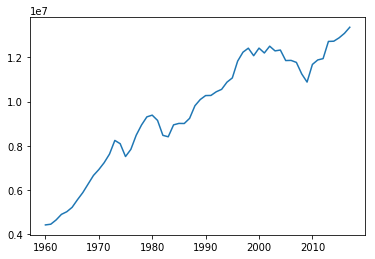

In [64]:
tx_TotalEnergy_consumption= tx_energy[["Total_en_consumption"]]
tx_TotalEnergy_consumption.head()
plt.plot(tx_energy.Years,tx_TotalEnergy_consumption.Total_en_consumption)

In [65]:
scaler_tx_TotalEnergy_consumption  = MinMaxScaler(feature_range=(0, 1))
tx_TotalEnergy_consumption = scaler_tx_TotalEnergy_consumption.fit_transform(tx_TotalEnergy_consumption)

# split into train and test sets
train_size_tx_TotalEnergy_consumption  = int(len(tx_TotalEnergy_consumption) * 0.67)
test_size_tx_TotalEnergy_consumption  = len(tx_TotalEnergy_consumption) - train_size_tx_TotalEnergy_consumption 
train_tx_TotalEnergy_consumption , test_tx_TotalEnergy_consumption  = tx_TotalEnergy_consumption [0:train_size_tx_TotalEnergy_consumption,:], tx_TotalEnergy_consumption [train_size_tx_TotalEnergy_consumption :len(tx_TotalEnergy_consumption),:]

# convert an array of values into a dataset matrix
def create_tx_TotalEnergy_consumption(tx_TotalEnergy_consumption, look_back=1):
	dataX_tx_TotalEnergy_consumption, dataY_tx_TotalEnergy_consumption = [], []
	for i_tx_TotalEnergy_consumption in range(len(tx_TotalEnergy_consumption)-look_back-1):
		a_tx_TotalEnergy_consumption = tx_TotalEnergy_consumption[i_tx_TotalEnergy_consumption:(i_tx_TotalEnergy_consumption+look_back), 0]
		dataX_tx_TotalEnergy_consumption.append(a_tx_TotalEnergy_consumption)
		dataY_tx_TotalEnergy_consumption.append(tx_TotalEnergy_consumption[i_tx_TotalEnergy_consumption + look_back, 0])
	return numpy.array(dataX_tx_TotalEnergy_consumption), numpy.array(dataY_tx_TotalEnergy_consumption)

# reshape into X=t and Y=t+1
look_back = 1
trainX_tx_TotalEnergy_consumption, trainY_tx_TotalEnergy_consumption = create_tx_TotalEnergy_consumption(train_tx_TotalEnergy_consumption, look_back)
testX_tx_TotalEnergy_consumption, testY_tx_TotalEnergy_consumption = create_tx_TotalEnergy_consumption(test_tx_TotalEnergy_consumption, look_back)


# reshape input to be [samples, time steps, features]
trainX_tx_TotalEnergy_consumption = numpy.reshape(trainX_tx_TotalEnergy_consumption, (trainX_tx_TotalEnergy_consumption.shape[0], 1, trainX_tx_TotalEnergy_consumption.shape[1]))
testX_tx_TotalEnergy_consumption = numpy.reshape(testX_tx_TotalEnergy_consumption, (testX_tx_TotalEnergy_consumption.shape[0], 1, testX_tx_TotalEnergy_consumption.shape[1]))

# create and fit the LSTM network
model_tx_TotalEnergy_consumption = Sequential()
model_tx_TotalEnergy_consumption.add(LSTM(4, input_shape=(1, look_back)))
model_tx_TotalEnergy_consumption.add(Dense(1))
model_tx_TotalEnergy_consumption.compile(loss='mean_squared_error', optimizer='adam')
model_tx_TotalEnergy_consumption.fit(trainX_tx_TotalEnergy_consumption, trainY_tx_TotalEnergy_consumption, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 4s - loss: 0.2368
Epoch 2/100
 - 0s - loss: 0.1823
Epoch 3/100
 - 0s - loss: 0.1406
Epoch 4/100
 - 0s - loss: 0.1086
Epoch 5/100
 - 0s - loss: 0.0839
Epoch 6/100
 - 0s - loss: 0.0669
Epoch 7/100
 - 0s - loss: 0.0539
Epoch 8/100
 - 0s - loss: 0.0452
Epoch 9/100
 - 0s - loss: 0.0394
Epoch 10/100
 - 0s - loss: 0.0356
Epoch 11/100
 - 0s - loss: 0.0330
Epoch 12/100
 - 0s - loss: 0.0311
Epoch 13/100
 - 0s - loss: 0.0298
Epoch 14/100
 - 0s - loss: 0.0286
Epoch 15/100
 - 0s - loss: 0.0275
Epoch 16/100
 - 0s - loss: 0.0266
Epoch 17/100
 - 0s - loss: 0.0255
Epoch 18/100
 - 0s - loss: 0.0245
Epoch 19/100
 - 0s - loss: 0.0237
Epoch 20/100
 - 0s - loss: 0.0227
Epoch 21/100
 - 0s - loss: 0.0217
Epoch 22/100
 - 0s - loss: 0.0211
Epoch 23/100
 - 0s - loss: 0.0198
Epoch 24/100
 - 0s - loss: 0.0189
Epoch 25/100
 - 0s - loss: 0.0181
Epoch 26/100
 - 0s - loss: 0.0171
Epoch 27/100
 - 0s - loss: 0.0162
Epoch 28/100
 - 0s - loss: 0.0154
Epoch 29/100
 - 0s - loss: 0.0144
Epoch 30/100
 - 0s - lo

Train Score: 309887.97 RMSE
Test Score: 365571.64 RMSE


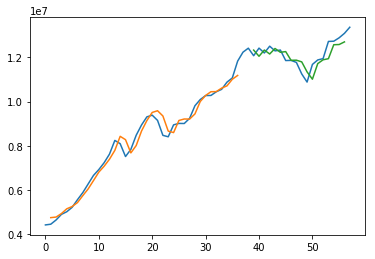

In [66]:
# make predictions
trainPredict_tx_TotalEnergy_consumption = model_tx_TotalEnergy_consumption.predict(trainX_tx_TotalEnergy_consumption)
testPredict_tx_TotalEnergy_consumption = model_tx_TotalEnergy_consumption.predict(testX_tx_TotalEnergy_consumption)
# invert predictions
trainPredict_tx_TotalEnergy_consumption = scaler_tx_TotalEnergy_consumption.inverse_transform(trainPredict_tx_TotalEnergy_consumption)
trainY_tx_TotalEnergy_consumption = scaler_tx_TotalEnergy_consumption.inverse_transform([trainY_tx_TotalEnergy_consumption])
testPredict_tx_TotalEnergy_consumption = scaler_tx_TotalEnergy_consumption.inverse_transform(testPredict_tx_TotalEnergy_consumption)
testY_tx_TotalEnergy_consumption = scaler_tx_TotalEnergy_consumption.inverse_transform([testY_tx_TotalEnergy_consumption])
# calculate root mean squared error
trainScore_tx_TotalEnergy_consumption = math.sqrt(mean_squared_error(trainY_tx_TotalEnergy_consumption[0], trainPredict_tx_TotalEnergy_consumption[:,0]))
print('Train Score: %.2f RMSE' % (trainScore_tx_TotalEnergy_consumption))
testScore_tx_TotalEnergy_consumption = math.sqrt(mean_squared_error(testY_tx_TotalEnergy_consumption[0], testPredict_tx_TotalEnergy_consumption[:,0]))
print('Test Score: %.2f RMSE' % (testScore_tx_TotalEnergy_consumption))

# shift train predictions for plotting
trainPredictPlot_tx_TotalEnergy_consumption = numpy.empty_like(tx_TotalEnergy_consumption)
trainPredictPlot_tx_TotalEnergy_consumption[:, :] = numpy.nan
trainPredictPlot_tx_TotalEnergy_consumption[look_back:len(trainPredict_tx_TotalEnergy_consumption)+look_back, :] = trainPredict_tx_TotalEnergy_consumption
# shift test predictions for plotting
testPredictPlot_tx_TotalEnergy_consumption = numpy.empty_like(tx_TotalEnergy_consumption)
testPredictPlot_tx_TotalEnergy_consumption[:, :] = numpy.nan
testPredictPlot_tx_TotalEnergy_consumption[len(trainPredict_tx_TotalEnergy_consumption)+(look_back*2)+1:len(tx_TotalEnergy_consumption)-1, :] = testPredict_tx_TotalEnergy_consumption
# plot baseline and predictions
plt.plot(scaler_tx_TotalEnergy_consumption.inverse_transform(tx_TotalEnergy_consumption))
plt.plot(trainPredictPlot_tx_TotalEnergy_consumption)
plt.plot(testPredictPlot_tx_TotalEnergy_consumption)
plt.show()

Epoch 1/100
 - 4s - loss: 0.2041
Epoch 2/100
 - 0s - loss: 0.0359
Epoch 3/100
 - 0s - loss: 0.0267
Epoch 4/100
 - 0s - loss: 0.0201
Epoch 5/100
 - 0s - loss: 0.0154
Epoch 6/100
 - 0s - loss: 0.0125
Epoch 7/100
 - 0s - loss: 0.0096
Epoch 8/100
 - 0s - loss: 0.0075
Epoch 9/100
 - 0s - loss: 0.0062
Epoch 10/100
 - 0s - loss: 0.0053
Epoch 11/100
 - 0s - loss: 0.0046
Epoch 12/100
 - 0s - loss: 0.0041
Epoch 13/100
 - 0s - loss: 0.0038
Epoch 14/100
 - 0s - loss: 0.0036
Epoch 15/100
 - 0s - loss: 0.0033
Epoch 16/100
 - 0s - loss: 0.0032
Epoch 17/100
 - 0s - loss: 0.0032
Epoch 18/100
 - 0s - loss: 0.0030
Epoch 19/100
 - 0s - loss: 0.0032
Epoch 20/100
 - 0s - loss: 0.0029
Epoch 21/100
 - 0s - loss: 0.0029
Epoch 22/100
 - 0s - loss: 0.0031
Epoch 23/100
 - 0s - loss: 0.0028
Epoch 24/100
 - 0s - loss: 0.0031
Epoch 25/100
 - 0s - loss: 0.0028
Epoch 26/100
 - 0s - loss: 0.0031
Epoch 27/100
 - 0s - loss: 0.0031
Epoch 28/100
 - 0s - loss: 0.0028
Epoch 29/100
 - 0s - loss: 0.0028
Epoch 30/100
 - 0s - lo

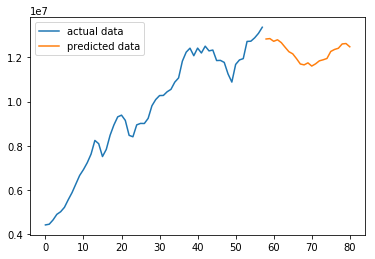

In [67]:
# re-train the LSTM on all data
look_back = 30 # look back further
trainX_tx_TotalEnergy_consumption, trainY_tx_TotalEnergy_consumption = create_tx_TotalEnergy_consumption(tx_TotalEnergy_consumption, look_back)
trainX_tx_TotalEnergy_consumption = numpy.reshape(trainX_tx_TotalEnergy_consumption, (trainX_tx_TotalEnergy_consumption.shape[0], 1, trainX_tx_TotalEnergy_consumption.shape[1]))

# re-create and fit the LSTM network
model_tx_TotalEnergy_consumption = Sequential()
model_tx_TotalEnergy_consumption.add(LSTM(4, input_shape=(1, look_back)))
model_tx_TotalEnergy_consumption.add(Dense(1))
model_tx_TotalEnergy_consumption.compile(loss='mean_squared_error', optimizer='adam')
model_tx_TotalEnergy_consumption.fit(trainX_tx_TotalEnergy_consumption, trainY_tx_TotalEnergy_consumption, epochs=100, batch_size=1, verbose=2)


# making future prediction
flatten_tx_TotalEnergy_consumption = tx_TotalEnergy_consumption.reshape(-1)
val_tx_TotalEnergy_consumption = flatten_tx_TotalEnergy_consumption[-look_back:] # last batch in the training data
pred_list_tx_TotalEnergy_consumption = []
for i_tx_TotalEnergy_consumption in range(23): # predict the next 23 points
    pred_tx_TotalEnergy_consumption = model_tx_TotalEnergy_consumption.predict(val_tx_TotalEnergy_consumption.reshape(1,1,look_back))
    pred_list_tx_TotalEnergy_consumption = np.append(pred_list_tx_TotalEnergy_consumption,pred_tx_TotalEnergy_consumption)
    val_tx_TotalEnergy_consumption = np.append(np.delete(val_tx_TotalEnergy_consumption, 0),pred_tx_TotalEnergy_consumption) # update the data batch to be fed in the next iteration
pred_list_tx_TotalEnergy_consumption = pred_list_tx_TotalEnergy_consumption.reshape(pred_list_tx_TotalEnergy_consumption.shape[0],1)

# invert prediction
pred_list_tx_TotalEnergy_consumption = scaler_tx_TotalEnergy_consumption.inverse_transform(pred_list_tx_TotalEnergy_consumption)

# plot
tx_TotalEnergy_consumption_len = len(tx_TotalEnergy_consumption)
print(tx_oil_len)
plt.plot(list(range(tx_TotalEnergy_consumption_len)),scaler_tx_TotalEnergy_consumption.inverse_transform(tx_TotalEnergy_consumption),label="actual data")
plt.plot(list(range(tx_TotalEnergy_consumption_len,tx_TotalEnergy_consumption_len+len(pred_list_tx_TotalEnergy_consumption))),pred_list_tx_TotalEnergy_consumption,label="predicted data")
plt.legend()
plt.show()

texas renewable energy production 1965-2040

In [68]:
L_TotalEnergy_consumption = pred_list_tx_TotalEnergy_consumption
tx_TotalEnergy_consumption_pre = pd.DataFrame(L_TotalEnergy_consumption, columns=["Total_en_consumption"])

TotalEnergy_consumption_pred = pd.concat([pre_yrs, tx_TotalEnergy_consumption_pre], axis=1, sort=False)
TotalEnergy_consumption_pred.head()
tx_TotalEnergy_consumption = tx_energy[["Years", "Total_en_consumption"]]
tx_TotalEnergy_consumption.head()
TexasTotalEnergy_consumption_prod_pre = pd.concat([tx_TotalEnergy_consumption, TotalEnergy_consumption_pred])
TexasTotalEnergy_consumption_prod_pre.head()


,Years,Total_en_consumption
0,1960,4416216.0
1,1961,4447880.0
2,1962,4640675.0
3,1963,4894089.0
4,1964,5012683.0


# merge all productions/predictions into one dataframe 

In [69]:
from functools import reduce
dfs = [TexasCoal_prod_pre, TexasOil_prod_pre, Texasgas_prod_pre, TexasRenewable_prod_pre, TexasTotalEnergy_prod_pre, TexasTotalEnergy_consumption_prod_pre]

TexasEnergy = reduce(lambda left,right: pd.merge(left,right,on='Years'), dfs)
TexasEnergy

,Years,Coal_prod,Oil_prod,Gas_prod,Renewable_en_prod,Total_en_prod,Total_en_consumption
0,1960,26409.000000,5.379378e+06,6.602696e+06,5.015500e+04,1.205864e+07,4.416216e+06
1,1961,26535.000000,5.447308e+06,6.682140e+06,5.202300e+04,1.220801e+07,4.447880e+06
2,1962,25855.000000,5.471272e+06,6.812787e+06,4.772100e+04,1.235764e+07,4.640675e+06
3,1963,27441.000000,5.671135e+06,6.952455e+06,4.271800e+04,1.269375e+07,4.894089e+06
4,1964,28839.000000,5.739216e+06,7.311876e+06,4.388400e+04,1.312382e+07,5.012683e+06
5,1965,30349.000000,5.804308e+06,7.436127e+06,4.896700e+04,1.331975e+07,5.212184e+06
6,1966,28360.000000,6.127692e+06,7.746648e+06,5.198000e+04,1.395468e+07,5.557255e+06
7,1967,27102.000000,6.480449e+06,7.934585e+06,4.994400e+04,1.449208e+07,5.879030e+06
8,1968,28839.000000,6.555601e+06,8.271293e+06,6.293900e+04,1.491867e+07,6.268911e+06
9,1969,28310.000000,6.664147e+06,8.654795e+06,6.435100e+04,1.541160e+07,6.656323e+06


In [72]:

np.round(TexasEnergy, decimals=1)

,Years,Coal_prod,Oil_prod,Gas_prod,Renewable_en_prod,Total_en_prod,Total_en_consumption
0,1960,26409.0,5379378.0,6602696.0,50155.0,12058639.0,4416216.0
1,1961,26535.0,5447308.0,6682140.0,52023.0,12208006.0,4447880.0
2,1962,25855.0,5471272.0,6812787.0,47721.0,12357635.0,4640675.0
3,1963,27441.0,5671135.0,6952455.0,42718.0,12693749.0,4894089.0
4,1964,28839.0,5739216.0,7311876.0,43884.0,13123816.0,5012683.0
5,1965,30349.0,5804308.0,7436127.0,48967.0,13319750.0,5212184.0
6,1966,28360.0,6127692.0,7746648.0,51980.0,13954680.0,5557255.0
7,1967,27102.0,6480449.0,7934585.0,49944.0,14492080.0,5879030.0
8,1968,28839.0,6555601.0,8271293.0,62939.0,14918671.0,6268911.0
9,1969,28310.0,6664147.0,8654795.0,64351.0,15411603.0,6656323.0


In [73]:
TexasEnergy.to_csv("TexasEnergy_60_65.csv")


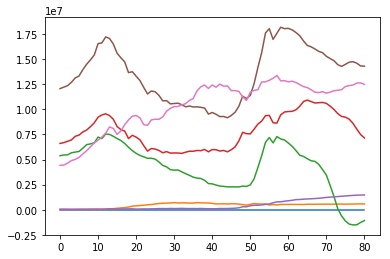

In [74]:
plt.plot(TexasEnergy)